# **Toxicity Detection**

# Importing the Necessary Libraries

In [ ]:
pip install umap-learn

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 90.9/90.9 kB 2.0 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.1/1.1 MB 13.2 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Created wheel for umap-learn: filename=umap_learn-0.5.5-py3-none-any.whl size=86831 sha256=74b2fe2893f2ba27aae1dafb727fcbb56230e85f71f4318cd5b2f8a7a9542681
  Stored in directory: /root/.cache/pip/wheels/3a/70/07/428d2b58660a1a3b431db59b806a10da736612ebbc66c1bcc5
  Created wheel for pynndescent: filename=pynndescent-0.5.10-py3-none-any.whl size=55615 sha256=b1d1da3787948282ea66681fe24a5d0084c2bf27b059193c3b7a25edc8852635
  Stored in directory: /root/.cache/pip/wheels/4a/38/5d/f60a40a66a9512b7e5e83517ebc2d1b42d857be97d135f1096
Successfully built umap-learn pynndescent


In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import re
import nltk
import plotly.graph_objects as go
import umap

In [ ]:
from google.colab import drive

In [ ]:
from nltk.corpus import stopwords

In [ ]:
from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer
from sklearn.decomposition import PCA
from sklearn.cluster import KMeans, DBSCAN, AgglomerativeClustering
from sklearn.preprocessing import StandardScaler

In [ ]:
from mpl_toolkits.mplot3d import Axes3D

In [ ]:
from scipy.cluster.hierarchy import dendrogram, linkage

In [ ]:
drive.mount('/content/drive')

Mounted at /content/drive


# Data Exploration and Preprocessing

## Number of Samples in Train and Test Datasets

In [ ]:
df_train = pd.read_csv('/content/drive/MyDrive/NaUKMA/ML/ToxicityDetection/train.csv')
df_test = pd.read_csv('/content/drive/MyDrive/NaUKMA/ML/ToxicityDetection/test.csv')

In [ ]:
df_train.head()

,id,comment_text,toxic,severe_toxic,obscene,threat,insult,identity_hate
0,0000997932d777bf,Explanation\nWhy the edits made under my usern...,0,0,0,0,0,0
1,000103f0d9cfb60f,D'aww! He matches this background colour I'm s...,0,0,0,0,0,0
2,000113f07ec002fd,"Hey man, I'm really not trying to edit war. It...",0,0,0,0,0,0
3,0001b41b1c6bb37e,"""\nMore\nI can't make any real suggestions on ...",0,0,0,0,0,0
4,0001d958c54c6e35,"You, sir, are my hero. Any chance you remember...",0,0,0,0,0,0


In [ ]:
df_test.head()

,Unnamed: 0,id,comment_text
0,5,0001ea8717f6de06,Thank you for understanding. I think very high...
1,7,000247e83dcc1211,:Dear god this site is horrible.
2,11,0002f87b16116a7f,"""::: Somebody will invariably try to add Relig..."
3,13,0003e1cccfd5a40a,""" \n\n It says it right there that it IS a typ..."
4,14,00059ace3e3e9a53,""" \n\n == Before adding a new product to the l..."


In [ ]:
df_train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 159571 entries, 0 to 159570
Data columns (total 8 columns):
 #   Column         Non-Null Count   Dtype 
---  ------         --------------   ----- 
 0   id             159571 non-null  object
 1   comment_text   159571 non-null  object
 2   toxic          159571 non-null  int64 
 3   severe_toxic   159571 non-null  int64 
 4   obscene        159571 non-null  int64 
 5   threat         159571 non-null  int64 
 6   insult         159571 non-null  int64 
 7   identity_hate  159571 non-null  int64 
dtypes: int64(6), object(2)
memory usage: 9.7+ MB


Here we see that train dataset contains **159571** samples.

In [ ]:
df_test.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 63978 entries, 0 to 63977
Data columns (total 3 columns):
 #   Column        Non-Null Count  Dtype 
---  ------        --------------  ----- 
 0   Unnamed: 0    63978 non-null  int64 
 1   id            63978 non-null  object
 2   comment_text  63978 non-null  object
dtypes: int64(1), object(2)
memory usage: 1.5+ MB


The test dataset contains **63978** samples.

## Sample Stats

Next we define some utility functions for viewing the dataset statistics.

In [ ]:
def show_percentiles(df, col, name):
  # Calculating the counts that cover 100%, 90%, 80%, ..., 10% of the rows
  percentiles = list(range(100, 0, -10))
  counts_percentiles = np.percentile(df[col], percentiles)

  # Displaying the counts at each percentile
  for percentile, count in zip(percentiles, counts_percentiles):
      print(f"{percentile}% of the rows have at most {int(count)} {name}s.")

In [ ]:
def plot_hist(col, name, range=100):
  # Creating a histogram of counts for df_train
  plt.hist(df_train[col], bins=50, range=(0, range), alpha=0.5, label='Train Data')
  # Creating a histogram of counts for df_test
  plt.hist(df_test[col], bins=50, range=(0, range), alpha=0.5, label='Test Data')

  plt.xlabel(f'Number of {name}s')
  plt.ylabel('Frequency')
  plt.title(f'Histogram of {name} Counts')
  plt.legend()  # Adding a legend to distinguish between train and test data
  plt.show()

The first statistic that interests us is the number of words in every sample.

In [ ]:
df_train['word_count'] = df_train['comment_text'].apply(lambda x: len(x.split()))
df_test['word_count'] = df_test['comment_text'].apply(lambda x: len(x.split()))

In [ ]:
print("In df_train:")
show_percentiles(df_train, 'word_count', 'word')

In df_train:
100% of the rows have at most 1411 words.
90% of the rows have at most 152 words.
80% of the rows have at most 91 words.
70% of the rows have at most 63 words.
60% of the rows have at most 47 words.
50% of the rows have at most 36 words.
40% of the rows have at most 27 words.
30% of the rows have at most 20 words.
20% of the rows have at most 14 words.
10% of the rows have at most 8 words.


In [ ]:
print("In df_test:")
show_percentiles(df_test, 'word_count', 'word')

In df_test:
100% of the rows have at most 2321 words.
90% of the rows have at most 143 words.
80% of the rows have at most 86 words.
70% of the rows have at most 60 words.
60% of the rows have at most 45 words.
50% of the rows have at most 34 words.
40% of the rows have at most 25 words.
30% of the rows have at most 18 words.
20% of the rows have at most 12 words.
10% of the rows have at most 7 words.


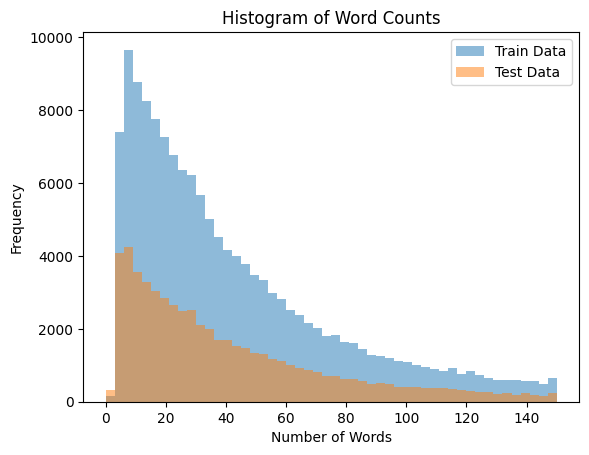

In [ ]:
plot_hist('word_count', 'Word', range=150)

Next we display the distribution of character counts in different samples.

In [ ]:
# Calculating text lengths and creating a new column
df_train['char_count'] = df_train['comment_text'].apply(len)
df_test['char_count'] = df_test['comment_text'].apply(len)

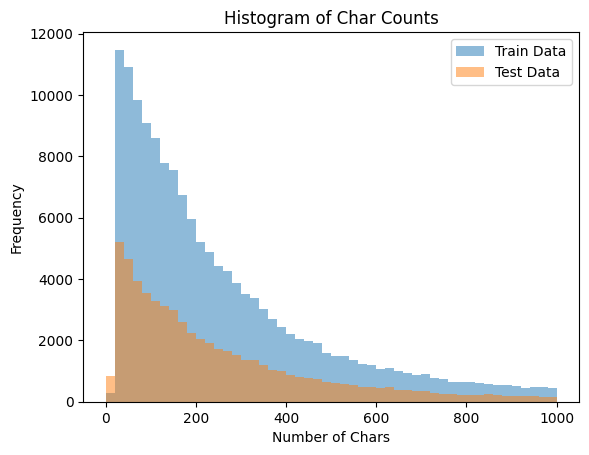

In [ ]:
plot_hist('char_count', 'Char', range=1000)

Finally, we display the distribution of capital letter counts in different samples.

In [ ]:
df_train['capital_letter_count'] = df_train['comment_text'].apply(lambda x: sum(1 for c in x if c.isupper()))
df_test['capital_letter_count'] = df_test['comment_text'].apply(lambda x: sum(1 for c in x if c.isupper()))

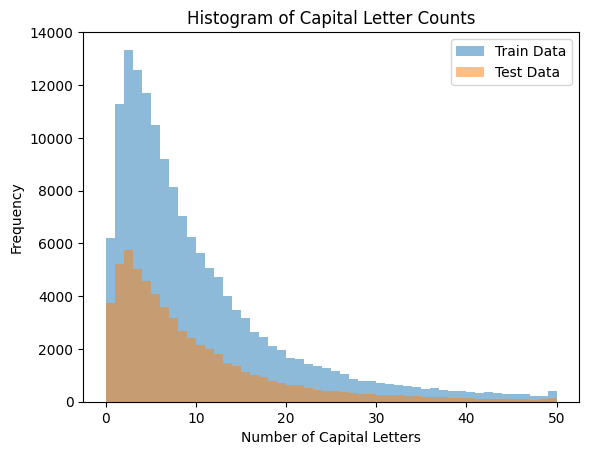

In [ ]:
plot_hist('capital_letter_count', 'Capital Letter', range=50)

## Text Cleaning

In [ ]:
train_texts = [text for text in df_train['comment_text']]
test_texts = [text for text in df_test['comment_text']]

In [ ]:
labels_toxic = [val for val in df_train['toxic']]
labels_severe_toxic = [val for val in df_train['severe_toxic']]
labels_obscene = [val for val in df_train['obscene']]
labels_threat = [val for val in df_train['threat']]
labels_insult = [val for val in df_train['insult']]
labels_identity_hate = [val for val in df_train['identity_hate']]

Next we define a utility function to filter special symbols.

In [ ]:
def remove_special_symbols(texts):
    # Defining a regular expression pattern to match special symbols
    special_symbol_pattern = r'[^A-Za-z\s]'  # This pattern matches anything that is not a letter, digit, or whitespace

    # Creating a list to store the filtered texts
    filtered_texts = []

    # Iterating through each text and removing special symbols
    for text in texts:
        filtered_text = re.sub(special_symbol_pattern, '', text)
        filtered_texts.append(filtered_text)

    return filtered_texts

In [ ]:
filtered_train_texts = remove_special_symbols(train_texts)
filtered_test_texts = remove_special_symbols(test_texts)

Here is an example sentence together with its clean version.

In [ ]:
test_texts[7], filtered_test_texts[7]

('|blocked]] from editing Wikipedia.   |', 'blocked from editing Wikipedia   ')

## Converting Text to Vectors

As the last preprocessing step, we convert our texts to vectors using TfidfVectorizer.

In [ ]:
# Choosing max_features value
max_features = 500

# Initializing the TfidfVectorizer
tfidf_vectorizer = TfidfVectorizer(max_features=max_features)

# Fitting and transforming the training data
X_train_tfidf = tfidf_vectorizer.fit_transform(filtered_train_texts)

# Transforming the test data
X_test_tfidf = tfidf_vectorizer.transform(filtered_test_texts)

In [ ]:
X_train_tfidf.shape, X_test_tfidf.shape

((159571, 500), (63978, 500))

In [ ]:
tfidf_vectorizer.vocabulary_

{'why': 471,
 'the': 410,
 'edits': 119,
 'made': 236,
 'under': 438,
 'my': 261,
 'were': 462,
 'reverted': 345,
 'they': 417,
 'just': 210,
 'on': 286,
 'some': 373,
 'after': 10,
 'at': 37,
 'new': 269,
 'and': 22,
 'please': 310,
 'dont': 112,
 'remove': 339,
 'template': 401,
 'from': 147,
 'talk': 399,
 'page': 300,
 'since': 370,
 'im': 188,
 'now': 279,
 'he': 171,
 'this': 421,
 'with': 477,
 'thanks': 407,
 'utc': 448,
 'hey': 176,
 'man': 241,
 'really': 330,
 'not': 273,
 'trying': 436,
 'to': 430,
 'edit': 115,
 'war': 454,
 'its': 208,
 'that': 408,
 'is': 203,
 'removing': 341,
 'relevant': 337,
 'information': 197,
 'me': 247,
 'through': 426,
 'instead': 198,
 'of': 281,
 'seems': 359,
 'care': 66,
 'more': 256,
 'about': 1,
 'than': 405,
 'info': 196,
 'cant': 65,
 'make': 238,
 'any': 25,
 'real': 329,
 'if': 186,
 'section': 356,
 'should': 366,
 'be': 44,
 'later': 217,
 'or': 291,
 'think': 420,
 'references': 335,
 'may': 245,
 'need': 265,
 'so': 372,
 'are': 30

In [ ]:
tfidf_vectorizer.stop_words_

{'continntia',
 'kanpur',
 'supervising',
 'wikipediapolicy',
 'coverd',
 'aggregator',
 'decemberstfreak',
 'agar',
 'madawc',
 'pinnochio',
 'motifs',
 'awakard',
 'jerkwater',
 'creme',
 'chipe',
 'trading',
 'corn',
 'bingham',
 'deletionusernewonelikesandbox',
 'phasedisplacementspacedrive',
 'levasseur',
 'talkfirefly',
 'adulerated',
 'httpthomaslocgovcgibinqueryzchconres',
 'blackmailer',
 'nuclearelectric',
 'avoided',
 'kanhai',
 'visine',
 'unlikely',
 'standardizestandardise',
 'leik',
 'polizei',
 'pitcairns',
 'tirol',
 'lucilius',
 'mescaline',
 'extraneous',
 'exemplars',
 'devise',
 'testquixotic',
 'redbluewhite',
 'baybe',
 'meeth',
 'communitywide',
 'unita',
 'ridin',
 'wannabees',
 'inscape',
 'ljls',
 'minorleague',
 'qweraquaraqwarinakara',
 'market',
 'mcra',
 'httpswwwyoutubecomwatchvrnilspmtc',
 'az',
 'bighex',
 'eliminiating',
 'gligorof',
 'reinstates',
 'zozo',
 'sidestepped',
 'daouds',
 'commonality',
 'thinly',
 'worldincluding',
 'respondend',
 'hmmsh

In [ ]:
X_train_dense = X_train_tfidf.toarray()
X_test_dense = X_test_tfidf.toarray()

# Dimensionality Reduction

## Utility Functions

In [ ]:
def visualize_3d(X, reduction_technique):
  # Creating a 3D scatter plot for the training data
  fig = plt.figure(figsize=(8, 6))
  ax = fig.add_subplot(111, projection='3d')
  ax.scatter(X[:, 0], X[:, 1], X[:, 2], label='Train Data', marker='o')

  # Adding labels and title
  ax.set_xlabel('Component 1')
  ax.set_ylabel('Component 2')
  ax.set_zlabel('Component 3')
  ax.set_title(f'3D {reduction_technique} Visualization of Training Data')
  ax.legend()

  # Showing the plot
  plt.show()

In [ ]:
def visualize_3d_labels(X):
  # Creating subplots
  fig, axes = plt.subplots(2, 3, figsize=(15, 10), sharex=True, sharey=True, subplot_kw=dict(projection='3d'))

  # Flattening the axes for easy iteration
  axes = axes.flatten()

  # List of label vectors and their names
  label_vectors = [labels_toxic, labels_severe_toxic, labels_obscene, labels_threat, labels_insult, labels_identity_hate]
  label_names = ['Toxic', 'Severe Toxic', 'Obscene', 'Threat', 'Insult', 'Identity Hate']

  # Plotting each label in a separate subplot
  for ax, label_vector, label_name in zip(axes, label_vectors, label_names):
      ax.scatter(X[:, 0], X[:, 1], X[:, 2], c=label_vector, cmap='viridis', marker='o')
      ax.set_title(label_name)
      ax.set_xlabel('Component 1')
      ax.set_ylabel('Component 2')
      ax.set_zlabel('Component 3')

  # Adjusting layout
  plt.tight_layout()

  # Showing the plot
  plt.show()

In [ ]:
def visualize_3d_interactive(X, labels=None, label_type=None):
  # Creating a 3D scatter plot for the training data
  fig = go.Figure()

  fig.add_trace(go.Scatter3d(
      x=X[:, 0],
      y=X[:, 1],
      z=X[:, 2],
      mode='markers',
      marker=dict(
          size=5,
          color='blue' if labels == None else labels,
          colorscale='Viridis',
          opacity=0.7
      ),
      name='Train Data' if label_type == None else label_type
  ))

  # Updating layout for better visibility
  fig.update_layout(
      scene=dict(
          xaxis_title='Component 1',
          yaxis_title='Component 2',
          zaxis_title='Component 3',
          xaxis=dict(backgroundcolor="rgb(200, 200, 230)"),
          yaxis=dict(backgroundcolor="rgb(230, 200,230)"),
          zaxis=dict(backgroundcolor="rgb(230, 230,200)")
      ),
      showlegend=True,
      height=600
  )

  # Showing the plot
  fig.show()

## PCA

To perform PCA, we shall first scale our data.

In [ ]:
scaler = StandardScaler()
X_train_dense_scaled = scaler.fit_transform(X_train_dense)
X_test_dense_scaled = scaler.transform(X_test_dense)

In [ ]:
# Initializing PCA with the desired number of components
n_components = 3 # 2min10sec for n_components = 500 and max_features=1000
pca = PCA(n_components=n_components)

# Fitting and transforming the training data
X_train_pca = pca.fit_transform(X_train_dense_scaled)

# Transforming the test data
X_test_pca = pca.transform(X_test_dense)

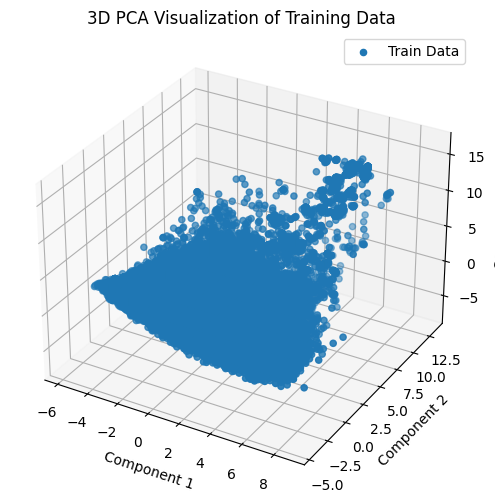

In [ ]:
visualize_3d(X_train_pca, 'PCA')

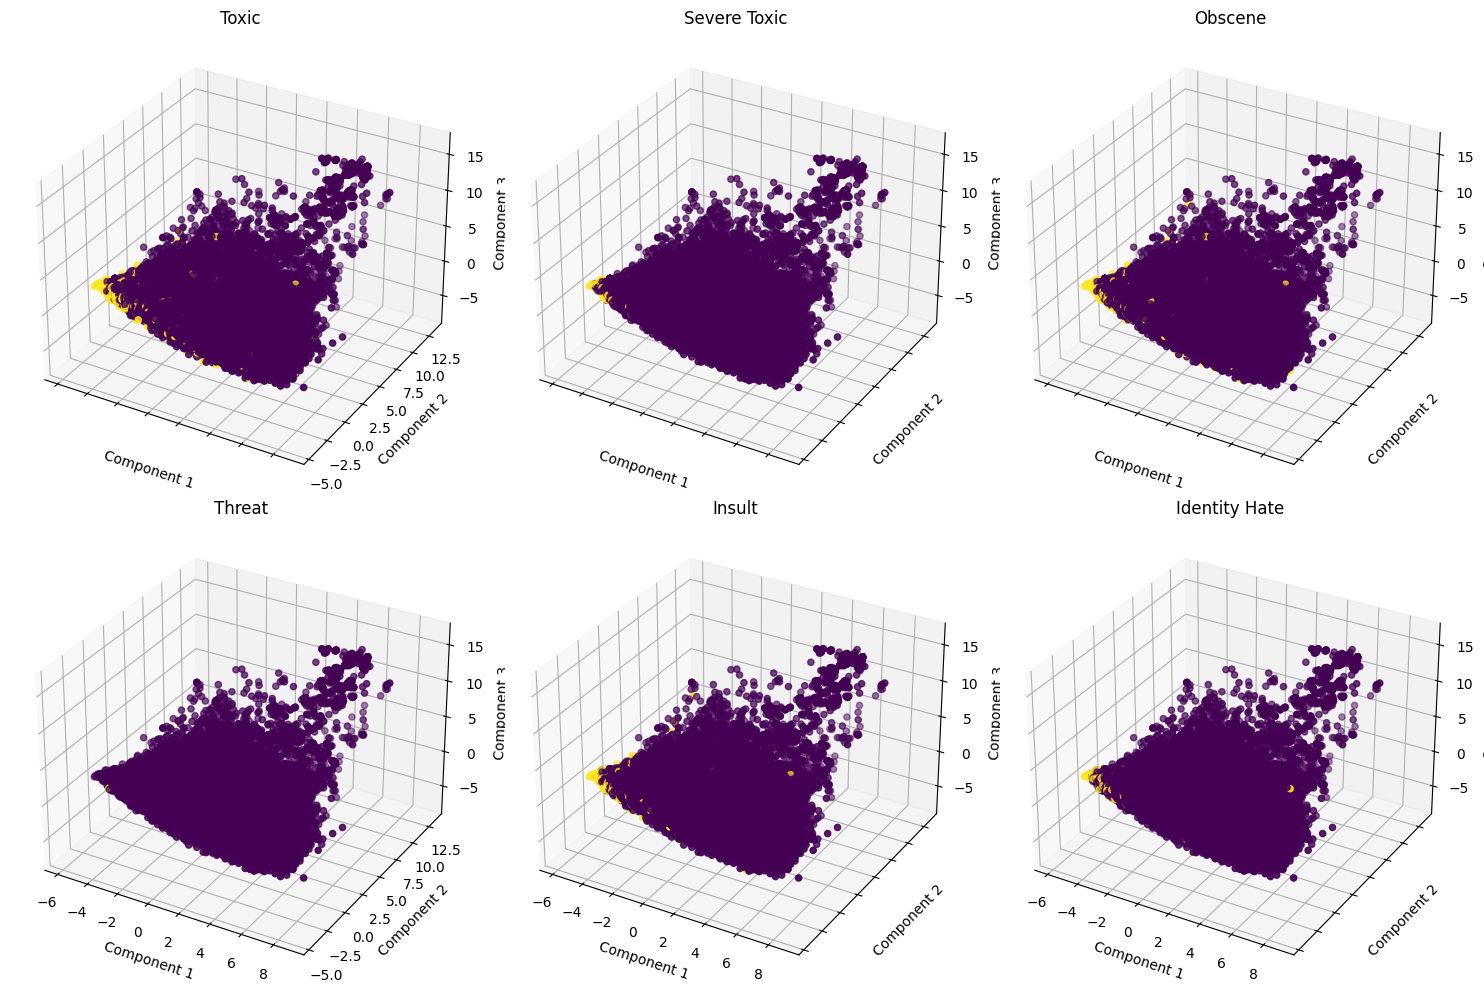

In [ ]:
visualize_3d_labels(X_train_pca)

In [ ]:
# Initializing PCA without specifying the number of components
pca = PCA()

# Fitting the PCA model to the training data
pca.fit(X_train_dense_scaled)

PCA()

Our next task is to learn how many components explain 80%, 90%, and 95% of total variance.

In [ ]:
# run with max_features=500
# Specifying the desired explained variance ratios
desired_explained_variance_ratios = [0.8, 0.9, 0.95]

# Dictionary to store results
pca_results = {}

for desired_explained_variance_ratio in desired_explained_variance_ratios:
    # Determining the number of components needed for the desired explained variance
    n_components = (pca.explained_variance_ratio_.cumsum() >= desired_explained_variance_ratio).argmax() + 1
    print(f"Components to achieve explained variance of {desired_explained_variance_ratio}: {n_components}")

Components to achieve explained variance of 0.8: 365
Components to achieve explained variance of 0.9: 425
Components to achieve explained variance of 0.95: 458


## UMAP

In [ ]:
# 11min to run with 1000 max_features, 7min with 500 max_features
# Initializing UMAP with the desired number of components
n_components_umap = 3

# Initializing UMAP model
umap_model = umap.UMAP(n_components=n_components_umap, n_epochs=100)

# Fitting and transforming the training data
X_train_umap = umap_model.fit_transform(X_train_dense)

# Printing the shape of the transformed data
print(f"X_train_umap shape: {X_train_umap.shape}")

X_train_umap shape: (159571, 3)


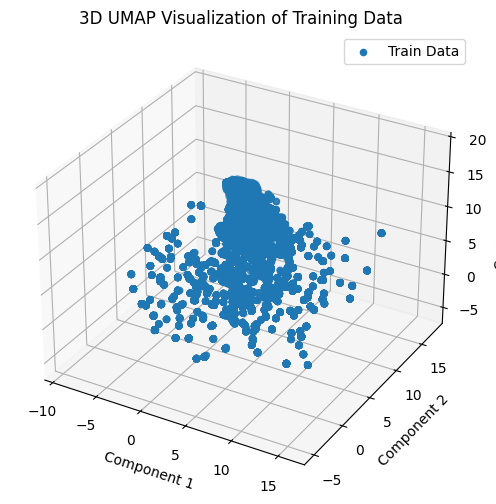

In [ ]:
visualize_3d(X_train_umap, 'UMAP')

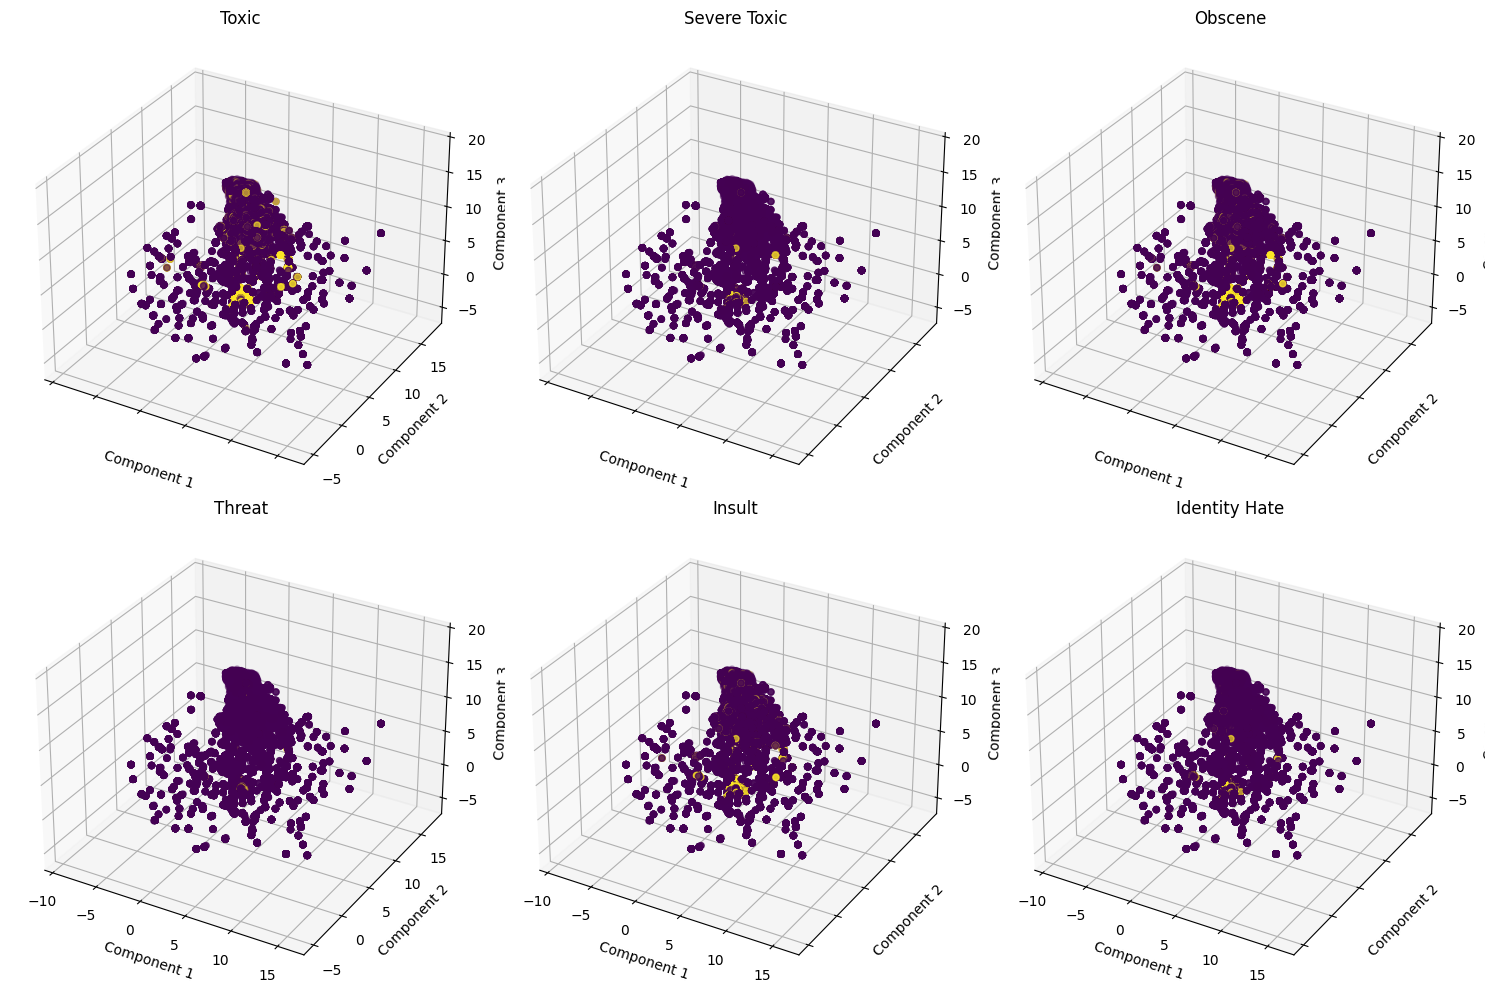

In [ ]:
visualize_3d_labels(X_train_umap)

# Clustering

## Preprocessing

In [ ]:
# Setting the seed for reproducibility
np.random.seed(42)

# Randomly sampling 10,000 indices
sampled_indices = np.random.choice(X_train_dense.shape[0], 10000, replace=False)

# Using the sampled indices to get the corresponding subset from X_train_dense
X_train_dense_sampled = X_train_dense[sampled_indices]

# Checking the shape of the sampled subset
print(f"Shape of sampled subset: {X_train_dense_sampled.shape}")

Shape of sampled subset: (10000, 500)


In [ ]:
# 56sec
# Initializing UMAP with the desired number of components
n_components_umap = 3

# Initializing UMAP model
umap_model = umap.UMAP(n_components=n_components_umap)

# Fitting and transforming the training data
X_train_umap_sampled = umap_model.fit_transform(X_train_dense_sampled)

# Printing the shape of the transformed data
print(f"X_train_umap_sampled shape: {X_train_umap_sampled.shape}")

X_train_umap_sampled shape: (10000, 3)


In [ ]:
def visualize_clusters(X, n_clusters, clusters, algorithm):
  # Visualizing the clustered data in 3D
  fig = plt.figure(figsize=(8, 6))
  ax = fig.add_subplot(111, projection='3d')

  # Scatter plot for each cluster
  for cluster_id in range(n_clusters):
      cluster_points = X[clusters == cluster_id]
      ax.scatter(cluster_points[:, 0], cluster_points[:, 1], cluster_points[:, 2], label=f'Cluster {cluster_id + 1}', marker='o')

  # Adding labels and title
  ax.set_xlabel('Component 1')
  ax.set_ylabel('Component 2')
  ax.set_zlabel('Component 3')
  ax.set_title(f'{algorithm} Clustering of UMAP-transformed Sampled Data')
  ax.legend()

  # Showing the plot
  plt.show()

## K-Means

In [ ]:
# Performing KMeans clustering
n_clusters = 5
kmeans = KMeans(n_clusters=n_clusters, n_init='auto', random_state=42)
clusters = kmeans.fit_predict(X_train_umap_sampled)

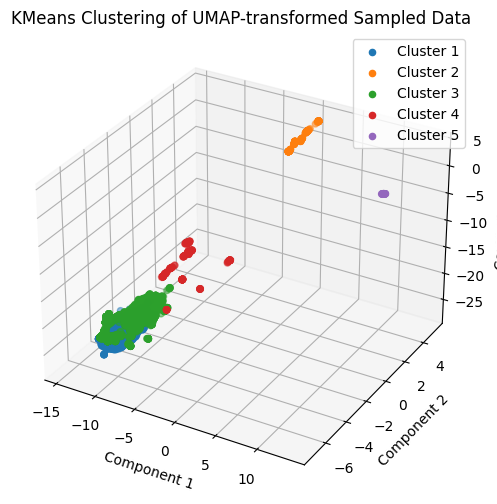

In [ ]:
visualize_clusters(X_train_umap_sampled, n_clusters, clusters, 'KMeans')

Let's find the best number of clusters using Elbow Method.

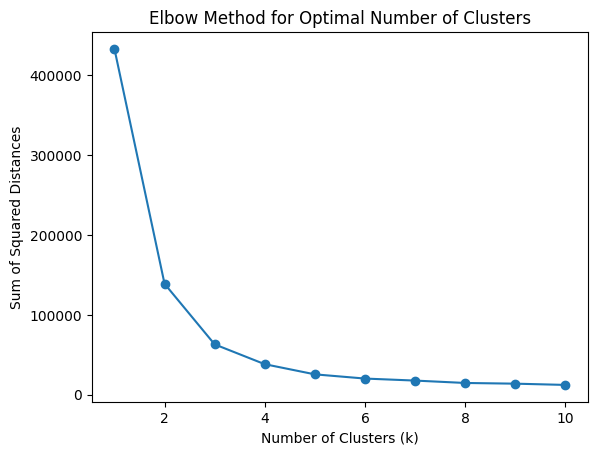

In [ ]:
# Specifying a range of cluster numbers
max_clusters = 10
sum_squared_distances = []

# Calculating sum of squared distances for different numbers of clusters
for k in range(1, max_clusters + 1):
    kmeans = KMeans(n_clusters=k, n_init='auto', random_state=42)
    kmeans.fit(X_train_umap_sampled)
    sum_squared_distances.append(kmeans.inertia_)

# Plotting the elbow curve
plt.plot(range(1, max_clusters + 1), sum_squared_distances, marker='o')
plt.xlabel('Number of Clusters (k)')
plt.ylabel('Sum of Squared Distances')
plt.title('Elbow Method for Optimal Number of Clusters')
plt.show()

**4** looks like the optimal number of clusters.

In [ ]:
# Performing KMeans clustering
n_clusters = 4
kmeans = KMeans(n_clusters=n_clusters, n_init='auto', random_state=42)
clusters = kmeans.fit_predict(X_train_umap_sampled)

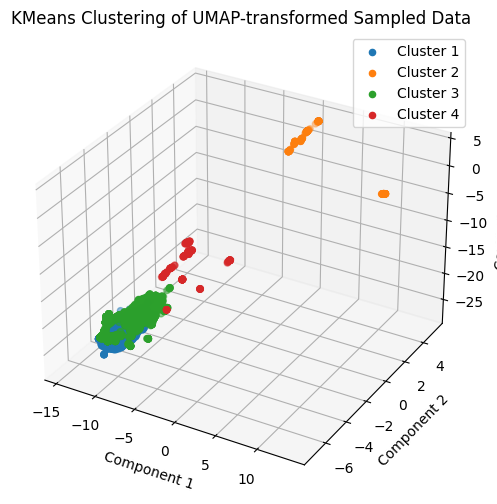

In [ ]:
visualize_clusters(X_train_umap_sampled, n_clusters, clusters, 'KMeans')

## DBSCAN

In [ ]:
# Performing DBSCAN clustering
dbscan = DBSCAN(eps=0.5, min_samples=10)
clusters = dbscan.fit_predict(X_train_umap_sampled)

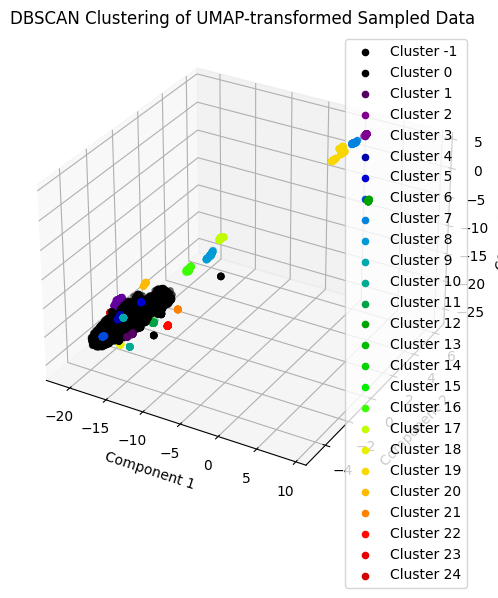

In [ ]:
# Visualizing the clustered data in 3D
fig = plt.figure(figsize=(8, 6))
ax = fig.add_subplot(111, projection='3d')

# Scatter plot for each cluster
unique_clusters = np.unique(clusters)
for cluster_id in unique_clusters:
    if cluster_id == -1:
        # Outliers (noise points) are shown in black
        color = 'black'
    else:
        # Regular clusters are assigned different colors
        color = plt.cm.nipy_spectral(cluster_id / len(unique_clusters))

    cluster_points = X_train_umap_sampled[clusters == cluster_id]
    ax.scatter(cluster_points[:, 0], cluster_points[:, 1], cluster_points[:, 2], label=f'Cluster {cluster_id}', color=color, marker='o')

# Adding labels and title
ax.set_xlabel('Component 1')
ax.set_ylabel('Component 2')
ax.set_zlabel('Component 3')
ax.set_title('DBSCAN Clustering of UMAP-transformed Sampled Data')
ax.legend()

# Showing the plot
plt.show()

## Hierarchical Clustering

In [ ]:
# Performing Agglomerative Clustering
n_clusters = 5
agg_clustering = AgglomerativeClustering(n_clusters=n_clusters)
clusters = agg_clustering.fit_predict(X_train_umap_sampled)

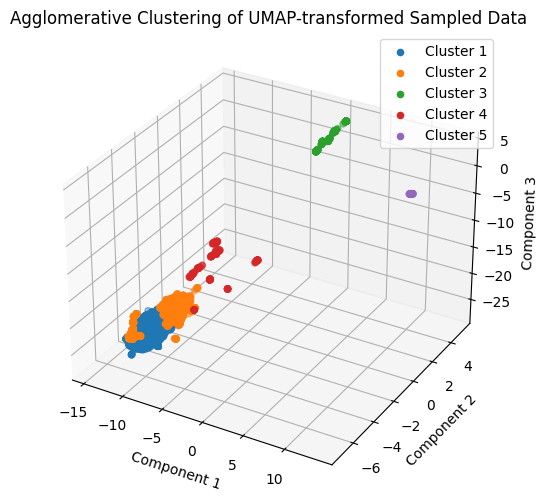

In [ ]:
visualize_clusters(X_train_umap_sampled, n_clusters, clusters, 'Agglomerative')